In [ ]:
# !pip install --upgrade google-api-python-client

In [1]:
from googleapiclient.discovery import build
from dateutil import parser
import pandas as pd
from IPython.display import JSON

# Data viz packages
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud
api_service_name = "youtube"
api_version = "v3"

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bltat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bltat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [53]:
from dotenv import load_dotenv
import os

api_key = "YOUR_API_KEY"
# print(api_key)
channel_ids=["UCCWi3hpnq_Pe03nGxuS7isg", 
             ]

# scopes = ["https://www.googleapis.com/auth/youtube.readonly"]

api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)

In [54]:
import pandas as pd


def get_channel_stats(youtube, channel_ids):
    
    all_data = []
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    # loop through items
    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
        }
        
        all_data.append(data)
        
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    video_ids = []
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    while next_page_token is not None:
        request = youtube.playlistItems().list(
                    part='contentDetails',
                    playlistId = playlist_id,
                    maxResults = 50,
                    pageToken = next_page_token)
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
    return video_ids
    
    
def get_video_details(youtube, video_ids):
    all_video_info = []
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
    
    return pd.DataFrame(all_video_info)
channel_stats = get_channel_stats(youtube, channel_ids)
channel_stats


,channelName,subscribers,views,totalVideos,playlistId
0,CampusX,173000,18332698,1172,UUCWi3hpnq_Pe03nGxuS7isg


In [95]:
playlist_id = "UUCWi3hpnq_Pe03nGxuS7isg"

In [96]:
# Get video IDs
video_ids = get_video_ids(youtube, playlist_id)
len(video_ids)

1038

In [97]:
# Get video details
video_df = get_video_details(youtube, video_ids)
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,zghjRYt8bcM,CampusX,Who is an AI Engineer | Rise of AI Engineer Ro...,An AI engineer is a professional responsible f...,"[Education, Engineering, Campus, Placement, Sk...",2024-03-19T02:52:50Z,21000,1701,None,798,PT40M13S,hd,false
1,o4ZVA0TuDRg,CampusX,"Why is Self Attention called ""Self""? | Self At...","The term ""self"" in ""self-attention"" refers to ...","[Education, Engineering, Campus, Placement, Sk...",2024-03-13T12:28:56Z,3532,189,None,41,PT22M35S,hd,false
2,5ZgGuujZSbs,CampusX,Self Attention Geometric Intuition | How to Vi...,Visualizing Self Attention offers insights int...,"[Education, Engineering, Campus, Placement, Sk...",2024-03-09T03:20:21Z,6814,283,None,43,PT20M52S,hd,false
3,r7mAt0iVqwo,CampusX,Scaled Dot Product Attention | Why do we scale...,Scaling Self Attention in Scaled Dot Product A...,"[Education, Engineering, Campus, Placement, Sk...",2024-03-01T13:50:43Z,6125,351,None,88,PT50M42S,hd,false
4,lbR3jQsenWk,CampusX,Master Jupyter Notebook with Python | End to E...,Jupyter Notebook is an open-source web applica...,"[Education, Engineering, Campus, Placement, Sk...",2024-02-26T05:50:33Z,14571,830,None,75,PT39M9S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,yvm1gaQXhSo,CampusX,Cumulative Distribution Function,Introduction to the concept of Cumulative Dist...,"[Statistics, Machine Learning, Data Science]",2019-08-09T17:32:34Z,3669,72,None,4,PT4M40S,hd,false
1034,_q5QTvMXPZ4,CampusX,Probability Density Function,Introduction to very important statistics conc...,"[Statistics, Machine Learning, Data Science]",2019-08-09T17:28:10Z,5691,151,None,8,PT13M49S,hd,false
1035,iifEWPR8BY8,CampusX,Descriptive Statistics - Measures of Spread,"A video explaining concepts like Range, IQR, V...","[Statistics, Machine Learning, Data Science]",2019-08-08T15:21:28Z,6216,170,None,21,PT23M49S,hd,false
1036,RwFK-BfY9ZY,CampusX,Descriptive Statistics - Measures of Central T...,A video to explain measures of centers like me...,"[Statistics, Machine Learning, Data Science]",2019-08-08T15:13:00Z,6307,166,None,11,PT12M26S,hd,false


In [98]:
# Check for NULL values
video_df.isnull().any()

video_id          False
channelTitle      False
title             False
description       False
tags               True
publishedAt       False
viewCount         False
likeCount         False
favouriteCount     True
commentCount      False
duration          False
definition        False
caption           False
dtype: bool

In [99]:
# Check data types
video_df.dtypes

video_id          object
channelTitle      object
title             object
description       object
tags              object
publishedAt       object
viewCount         object
likeCount         object
favouriteCount    object
commentCount      object
duration          object
definition        object
caption           object
dtype: object

In [100]:
# Convert count columns to numeric
numeric_cols = ['viewCount', 'likeCount', 'favouriteCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)
# Publish day in the week
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 
# convert duration to seconds
# import isodate

# video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
# video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')
# video_df[['durationSecs', 'duration']] 

# Add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))
video_df


,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,pushblishDayName,tagCount
0,zghjRYt8bcM,CampusX,Who is an AI Engineer | Rise of AI Engineer Ro...,An AI engineer is a professional responsible f...,"[Education, Engineering, Campus, Placement, Sk...",2024-03-19 02:52:50+00:00,21000.0,1701.0,NaN,798.0,PT40M13S,hd,false,Tuesday,9
1,o4ZVA0TuDRg,CampusX,"Why is Self Attention called ""Self""? | Self At...","The term ""self"" in ""self-attention"" refers to ...","[Education, Engineering, Campus, Placement, Sk...",2024-03-13 12:28:56+00:00,3532.0,189.0,NaN,41.0,PT22M35S,hd,false,Wednesday,9
2,5ZgGuujZSbs,CampusX,Self Attention Geometric Intuition | How to Vi...,Visualizing Self Attention offers insights int...,"[Education, Engineering, Campus, Placement, Sk...",2024-03-09 03:20:21+00:00,6814.0,283.0,NaN,43.0,PT20M52S,hd,false,Saturday,9
3,r7mAt0iVqwo,CampusX,Scaled Dot Product Attention | Why do we scale...,Scaling Self Attention in Scaled Dot Product A...,"[Education, Engineering, Campus, Placement, Sk...",2024-03-01 13:50:43+00:00,6125.0,351.0,NaN,88.0,PT50M42S,hd,false,Friday,9
4,lbR3jQsenWk,CampusX,Master Jupyter Notebook with Python | End to E...,Jupyter Notebook is an open-source web applica...,"[Education, Engineering, Campus, Placement, Sk...",2024-02-26 05:50:33+00:00,14571.0,830.0,NaN,75.0,PT39M9S,hd,false,Monday,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,yvm1gaQXhSo,CampusX,Cumulative Distribution Function,Introduction to the concept of Cumulative Dist...,"[Statistics, Machine Learning, Data Science]",2019-08-09 17:32:34+00:00,3669.0,72.0,NaN,4.0,PT4M40S,hd,false,Friday,3
1034,_q5QTvMXPZ4,CampusX,Probability Density Function,Introduction to very important statistics conc...,"[Statistics, Machine Learning, Data Science]",2019-08-09 17:28:10+00:00,5691.0,151.0,NaN,8.0,PT13M49S,hd,false,Friday,3
1035,iifEWPR8BY8,CampusX,Descriptive Statistics - Measures of Spread,"A video explaining concepts like Range, IQR, V...","[Statistics, Machine Learning, Data Science]",2019-08-08 15:21:28+00:00,6216.0,170.0,NaN,21.0,PT23M49S,hd,false,Thursday,3
1036,RwFK-BfY9ZY,CampusX,Descriptive Statistics - Measures of Central T...,A video to explain measures of centers like me...,"[Statistics, Machine Learning, Data Science]",2019-08-08 15:13:00+00:00,6307.0,166.0,NaN,11.0,PT12M26S,hd,false,Thursday,3


In [101]:
video_df.dtypes

video_id                             object
channelTitle                         object
title                                object
description                          object
tags                                 object
publishedAt         datetime64[ns, tzutc()]
viewCount                           float64
likeCount                           float64
favouriteCount                      float64
commentCount                        float64
duration                             object
definition                           object
caption                              object
pushblishDayName                     object
tagCount                              int64
dtype: object

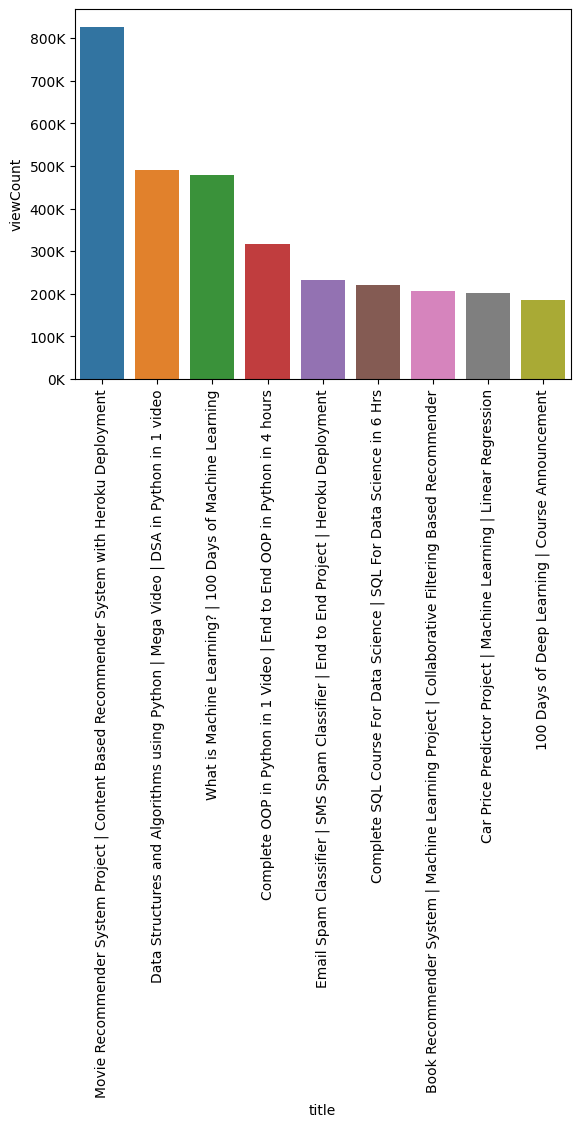

In [64]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=False)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

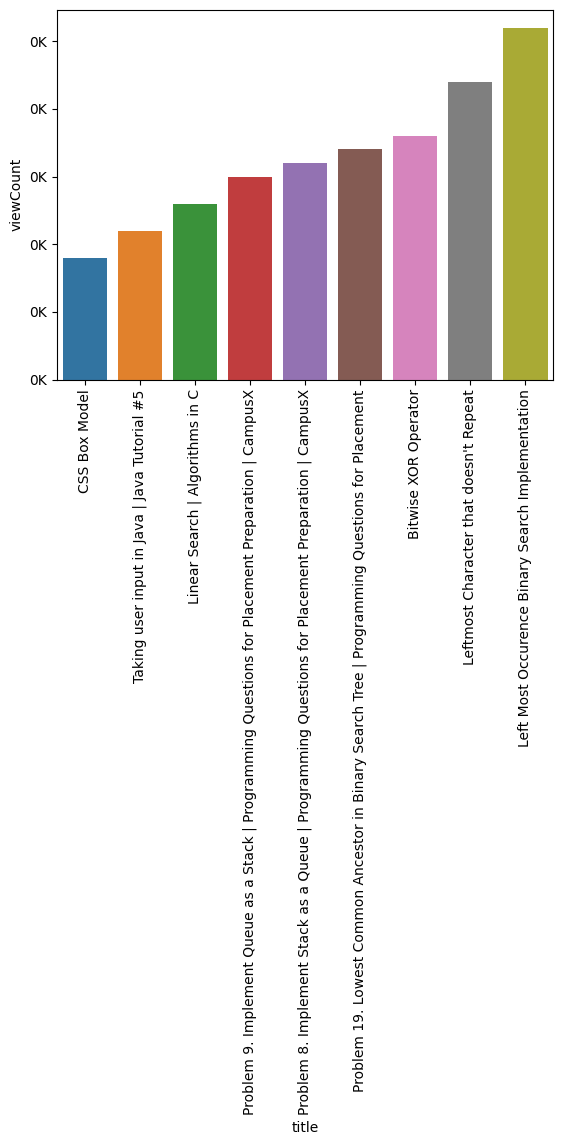

In [65]:
ax = sns.barplot(x = 'title', y = 'viewCount', data = video_df.sort_values('viewCount', ascending=True)[0:9])
plot = ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))

<AxesSubplot: xlabel='channelTitle', ylabel='viewCount'>

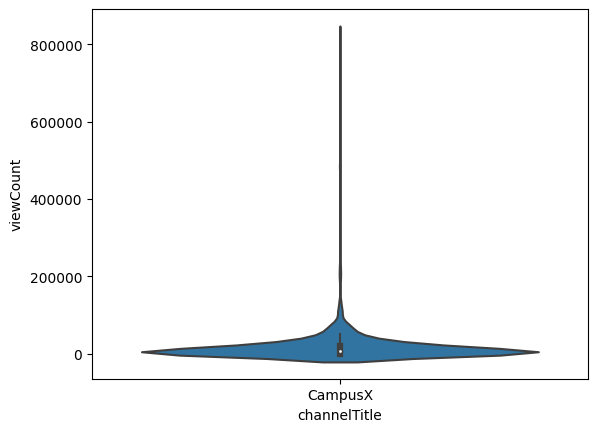

In [66]:
sns.violinplot(x = video_df['channelTitle'], y = video_df['viewCount'])

<AxesSubplot: xlabel='likeCount', ylabel='viewCount'>

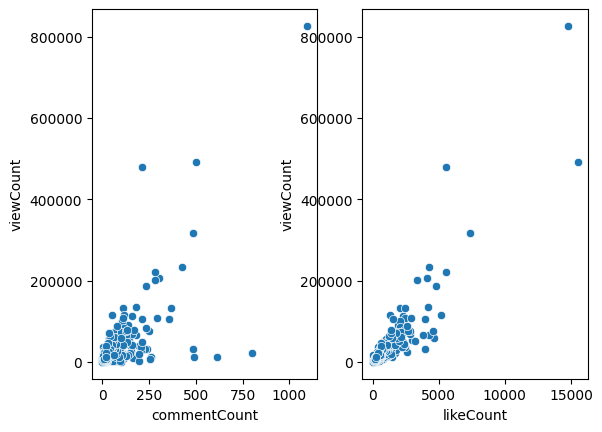

In [67]:
fig, ax = plt.subplots(1,2)
sns.scatterplot(data = video_df, x = 'commentCount', y = 'viewCount', ax = ax[0])
sns.scatterplot(data = video_df, x = 'likeCount', y = 'viewCount', ax = ax[1])

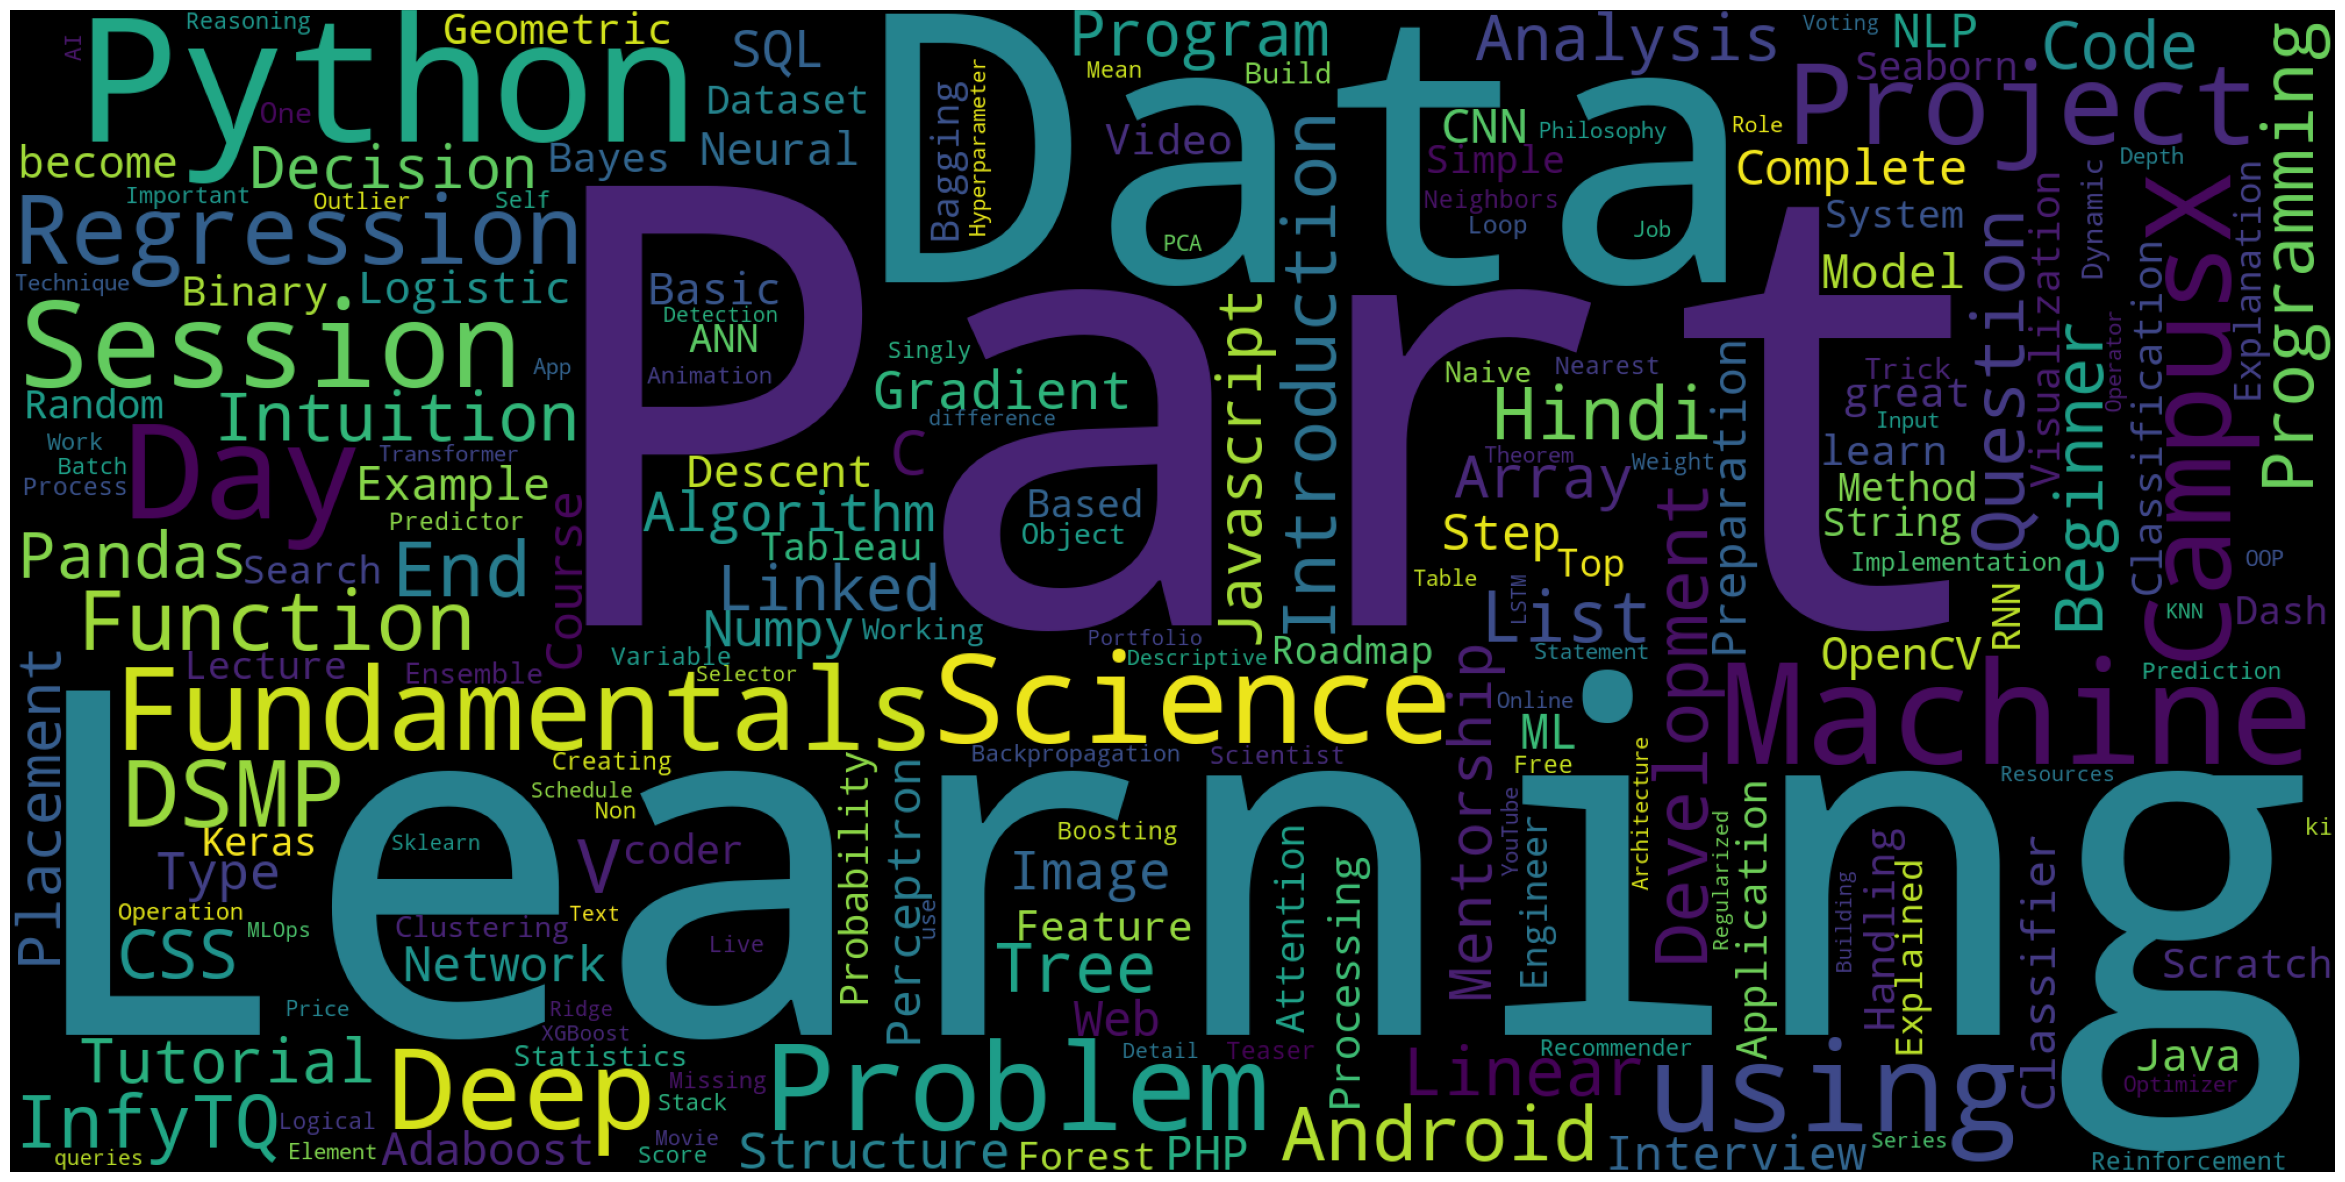

In [68]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])

all_words_str = ' '.join(all_words) 

def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off")

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='viridis', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

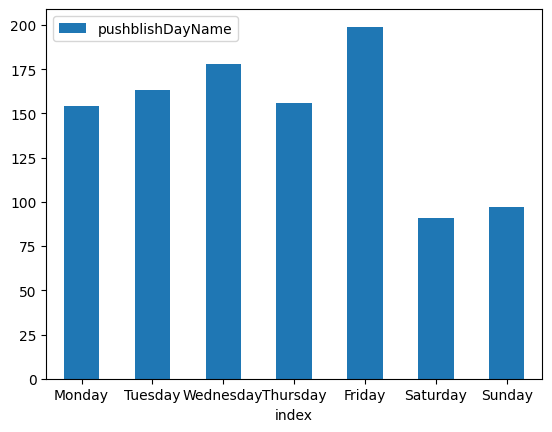

In [69]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)

## Comment Analysis


In [71]:
# 8F801HMrdp0
import requests
video_id = "zghjRYt8bcM"

In [92]:

video_info_url = f"https://www.googleapis.com/youtube/v3/videos?part=snippet&id={video_id}&key={api_key}"
video_info_response = requests.get(video_info_url)
video_info_data = video_info_response.json()

In [93]:
video_info_data

{'kind': 'youtube#videoListResponse',
 'etag': 'oyhQO8tBqXV1O-vzoDoR2T7ZeMQ',
 'items': [{'kind': 'youtube#video',
   'etag': 'Xpit4bG8qF0n4HRc0MHsSi1fjps',
   'id': 'zghjRYt8bcM',
   'snippet': {'publishedAt': '2024-03-19T02:52:50Z',
    'channelId': 'UCCWi3hpnq_Pe03nGxuS7isg',
    'title': 'Who is an AI Engineer | Rise of AI Engineer Role in 2024 | Data Scientist Vs AI Engineer in Hindi',
    'description': "An AI engineer is a professional responsible for developing, programming, and training complex networks of algorithms that make up artificial intelligence (AI) to function like a human brain. AI engineers use AI and machine learning techniques to develop applications, systems, and tools that enable the application of AI in various fields such as finance, national security, healthcare, criminal justice, etc.\n\n In this video, we have tried to explain who is an AI engineer and should you actually pursue this role?\n\n============================\nCheck my affordable mentorship pro

In [75]:
comment_url = f"https://www.googleapis.com/youtube/v3/commentThreads?part=snippet&videoId={video_id}&key={api_key}"
comment_response = requests.get(comment_url)
comment_data = comment_response.json()


In [76]:
comment_data

{'kind': 'youtube#commentThreadListResponse',
 'etag': 'qEH_1OPVuYfDSja2g-cC6i3gkz0',
 'nextPageToken': 'Z2V0X25ld2VzdF9maXJzdC0tQ2dnSWdBUVZGN2ZST0JJRkNLZ2dHQUFTQlFpSklCZ0FFZ1VJaUNBWUFCSUZDSjBnR0FFU0JRaUhJQmdBR0FBaURnb01DT1hEOUs4R0VJakl6b1lD',
 'pageInfo': {'totalResults': 20, 'resultsPerPage': 20},
 'items': [{'kind': 'youtube#commentThread',
   'etag': 'mu-wo4f-HHGF7q1rQYR04VYJLtI',
   'id': 'UgwkBsDuNE3l_PTqK6N4AaABAg',
   'snippet': {'channelId': 'UCCWi3hpnq_Pe03nGxuS7isg',
    'videoId': 'zghjRYt8bcM',
    'topLevelComment': {'kind': 'youtube#comment',
     'etag': 'ZNJ3j1HJ5B9bI-prcQRTbKDcqSw',
     'id': 'UgwkBsDuNE3l_PTqK6N4AaABAg',
     'snippet': {'channelId': 'UCCWi3hpnq_Pe03nGxuS7isg',
      'videoId': 'zghjRYt8bcM',
      'textDisplay': 'AI Engineer Roadmap pe video chahte ho? Niche👇comment karke batao! 💭',
      'textOriginal': 'AI Engineer Roadmap pe video chahte ho? Niche👇comment karke batao! 💭',
      'authorDisplayName': '@campusx-official',
      'authorProfileImageU

In [77]:
comments = [item["snippet"]["topLevelComment"]["snippet"]["textOriginal"] for item in comment_data["items"]]

In [78]:
print(comments)

['AI Engineer Roadmap pe video chahte ho? Niche👇comment karke batao! 💭', 'Please tell us about roadmap of ai engineer as there is no solid information about it on internet', 'PLEASE PLEASE PLEASE!!!!!\nYES sir, we want a video on a proper roadmap for AI Engineer.\nAfter that, also if possible start a course on it. :)', 'yes share road map', 'But fine tuning mein jo data hamara ho ga us ko clean or preprocess krne ke lie bhi to data scientist chaheiy??', "I'm a Data Scientist working as an AI Engineer but the thing is I'm not a good Software Developer. What resources can you point out that can help me out?", 'Yes, We want AI engineer Roadmap.', 'We need roadmap', 'Thank you sr i am eager to see next video on roadmap of ai engineer', 'Sir, Road map pls', 'Yes sir will love to get a detailed roadmap for this upcoming field', 'please make a roadmap', 'Sir aap comunity pe post dalte raha kro', 'Awesome', 'Sir please continue deep learning playlist', 'Yes share roadmap for becoming a compete

In [79]:
# !pip install textblob

In [80]:
from textblob import TextBlob
def get_comment_sentiment(comment):
    analysis = TextBlob(comment)
    if(analysis.sentiment.polarity)>0:
        return "  + positive + "
    elif (analysis.sentiment.polarity)==0:
        return " neutral :| "
    else:
        return "  - negative - "

In [81]:
for comment in comments:
    print(f"{comment}: {get_comment_sentiment(comment)}")

AI Engineer Roadmap pe video chahte ho? Niche👇comment karke batao! 💭:  neutral :| 
Please tell us about roadmap of ai engineer as there is no solid information about it on internet:  neutral :| 
PLEASE PLEASE PLEASE!!!!!
YES sir, we want a video on a proper roadmap for AI Engineer.
After that, also if possible start a course on it. :):   + positive + 
yes share road map:  neutral :| 
But fine tuning mein jo data hamara ho ga us ko clean or preprocess krne ke lie bhi to data scientist chaheiy??:   + positive + 
I'm a Data Scientist working as an AI Engineer but the thing is I'm not a good Software Developer. What resources can you point out that can help me out?:   - negative - 
Yes, We want AI engineer Roadmap.:  neutral :| 
We need roadmap:  neutral :| 
Thank you sr i am eager to see next video on roadmap of ai engineer:  neutral :| 
Sir, Road map pls:  neutral :| 
Yes sir will love to get a detailed roadmap for this upcoming field:   + positive + 
please make a roadmap:  neutral :| 


In [82]:
comment_text = [] 
comment_label = []
for comment in comments:
    comment_text.append(comment)
    print(comment)
    t = get_comment_sentiment(comment)
    print(t)
    comment_label.append(t)

AI Engineer Roadmap pe video chahte ho? Niche👇comment karke batao! 💭
 neutral :| 
Please tell us about roadmap of ai engineer as there is no solid information about it on internet
 neutral :| 
PLEASE PLEASE PLEASE!!!!!
YES sir, we want a video on a proper roadmap for AI Engineer.
After that, also if possible start a course on it. :)
  + positive + 
yes share road map
 neutral :| 
But fine tuning mein jo data hamara ho ga us ko clean or preprocess krne ke lie bhi to data scientist chaheiy??
  + positive + 
I'm a Data Scientist working as an AI Engineer but the thing is I'm not a good Software Developer. What resources can you point out that can help me out?
  - negative - 
Yes, We want AI engineer Roadmap.
 neutral :| 
We need roadmap
 neutral :| 
Thank you sr i am eager to see next video on roadmap of ai engineer
 neutral :| 
Sir, Road map pls
 neutral :| 
Yes sir will love to get a detailed roadmap for this upcoming field
  + positive + 
please make a roadmap
 neutral :| 
Sir aap comu

In [83]:
pd.DataFrame({'comments': comment_text, 'sentiment': comment_label})

,comments,sentiment
0,AI Engineer Roadmap pe video chahte ho? Niche👇...,neutral :|
1,Please tell us about roadmap of ai engineer as...,neutral :|
2,"PLEASE PLEASE PLEASE!!!!!\nYES sir, we want a ...",+ positive +
3,yes share road map,neutral :|
4,But fine tuning mein jo data hamara ho ga us k...,+ positive +
5,I'm a Data Scientist working as an AI Engineer...,- negative -
6,"Yes, We want AI engineer Roadmap.",neutral :|
7,We need roadmap,neutral :|
8,Thank you sr i am eager to see next video on r...,neutral :|
9,"Sir, Road map pls",neutral :|


In [84]:
df = pd.DataFrame({'comments': comment_text, 'sentiment': comment_label})
df.to_csv("youtube.csv")

In [89]:
positive = 0
neutral = 0
negative = 0
for i in df['sentiment']:
    if(i == "  + positive + "):
        positive = positive + 1
    elif(i == " neutral :| "):
        neutral = neutral + 1
    else:
        negative = negative + 1
        
print("Positive: ", positive)
print("Neutral: ", neutral)
print("Negative: ", negative)

Positive:  5
Neutral:  13
Negative:  2


# YouTube Data Analysis Documentation

## Introduction
This document provides an overview and documentation of a Python script designed to analyze data from YouTube channels and videos using the YouTube Data API. The script retrieves channel statistics, video details, performs data cleaning and analysis, and conducts sentiment analysis on comments for a given video.

## Dependencies
- `google-api-python-client`: A Python library to interact with Google's discovery-based APIs.
- `pandas`: A powerful data manipulation library for Python.
- `seaborn` and `matplotlib.pyplot`: Data visualization libraries for generating various plots and charts.
- `nltk`: Natural Language Toolkit for text processing tasks such as tokenization and stopword removal.
- `wordcloud`: A library for creating word clouds from text data.
- `dotenv`: A library for loading environment variables from a `.env` file.
- `requests`: A library for making HTTP requests.

## Setup
1. **Install Dependencies**: Ensure that the required Python libraries are installed. You can install them using pip:
   ```
   !pip install --upgrade google-api-python-client pandas seaborn matplotlib nltk wordcloud dotenv requests textblob
   ```

2. **Obtain API Key**: You need to obtain an API key from the Google Cloud Console to access the YouTube Data API. Make sure to enable the YouTube Data API v3 for your project.

3. **Environment Variables**: Store your API key in a `.env` file:
   ```
   YOUTUBE_API_KEY=your_api_key_here
   ```

## Script Overview
The script performs the following tasks:

1. **Import Libraries**: Imports necessary Python libraries for data retrieval, analysis, and visualization.

2. **Define API Key and Channel IDs**: Specifies the API key for accessing the YouTube Data API and defines the channel IDs for which data will be retrieved.

3. **Function Definitions**:
   - `get_channel_stats()`: Retrieves statistics for specified YouTube channels.
   - `get_video_ids()`: Retrieves video IDs from the uploads playlist of a channel.
   - `get_video_details()`: Retrieves detailed information for each video.
   - `get_comment_sentiment()`: Analyzes sentiment of YouTube comments.

4. **Data Retrieval and Processing**:
   - Retrieves channel statistics and video details using the defined functions.
   - Cleans and preprocesses the data, including handling missing values, converting data types, and extracting additional features.

5. **Data Analysis and Visualization**:
   - Generates various visualizations including bar plots, scatter plots, violin plots, and word clouds to analyze video and comment data.
   - Conducts sentiment analysis on comments using TextBlob library and visualizes sentiment distribution.

6. **Export Data**:
   - Saves the analyzed data to a CSV file for further analysis or reporting.

## Usage
- Ensure that you have set up the necessary environment variables and dependencies as described in the Setup section.
- Run the script in a Python environment such as Jupyter Notebook or a Python script editor.
- Modify the script as needed to analyze data from specific YouTube channels or videos.

## Conclusion
This script provides a comprehensive toolkit for analyzing YouTube channel and video data, including statistics, viewer engagement, and comment sentiment analysis. It can be adapted and extended for various research, marketing, or content creation purposes related to YouTube.


## Use cases

Certainly! Here are some potential use cases for the YouTube data analysis script:

1. **Content Strategy Optimization**: YouTube channel owners and content creators can use the script to analyze the performance of their videos, identify popular topics, and understand viewer engagement metrics such as likes, comments, and views. This information can help them refine their content strategy and create videos that resonate better with their audience.

2. **Competitor Analysis**: Marketers and businesses can use the script to analyze the performance of competitors' YouTube channels and videos. By comparing subscriber counts, view counts, and engagement metrics, they can gain insights into competitors' strategies and identify areas for improvement in their own content.

3. **Audience Insight**: Content creators, marketers, and brands can use the script to gain insights into their audience demographics and preferences. By analyzing comments, tags, and engagement metrics, they can understand what topics resonate with their audience and tailor their content accordingly.

4. **Ad Campaign Optimization**: Advertisers running YouTube ad campaigns can use the script to analyze the performance of their ads and identify trends in viewer engagement. By analyzing metrics such as view counts, likes, and comments, they can optimize their ad targeting and messaging to improve campaign effectiveness.

5. **Sentiment Analysis**: Businesses and brands can use the sentiment analysis feature of the script to analyze the sentiment of comments on their YouTube videos. By understanding the sentiment of viewer feedback, they can identify areas of customer satisfaction or dissatisfaction and take appropriate actions to address them.

6. **Trend Analysis**: Researchers and analysts can use the script to perform trend analysis on YouTube videos and channels. By analyzing metrics such as views over time, trending topics, and popular tags, they can identify emerging trends and patterns in online content consumption.

7. **Content Curation**: Media companies and content aggregators can use the script to curate relevant and popular YouTube videos for their audiences. By analyzing metrics such as view counts and engagement, they can identify high-quality and trending content to feature on their platforms.

These are just a few examples of how the YouTube data analysis script can be used to extract valuable insights and inform decision-making in various domains. The flexibility and versatility of the script make it a powerful tool for analyzing YouTube data for a wide range of purposes.